In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
import numpy as np
import pylab as plt
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold, cross_val_score

from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import multiprocessing

In [3]:
data = pd.read_csv('./train_data.csv')
label = pd.read_csv('./train_label.csv')

In [4]:
data['label'] = label['label']
data.head()

,desc,tweet,label
0,none,mariotti did your ancestors have to apply thro...,0
1,usmc veteran love god wife family dog and coun...,rule of law all the liberals including her wan...,0
2,none,rt japanmissionun thank you unicef unhcr nyoff...,0
3,we ve been referring people to law firms since...,know a good law firm in stirling immigration c...,0
4,i love life i love my family i love people,wall street ally with a skepticism of immigrat...,0


In [5]:
data.isnull().sum()

desc     27
tweet     0
label     0
dtype: int64

In [6]:
data = data.dropna().reset_index(drop = True)
data.isnull().sum()

desc     0
tweet    0
label    0
dtype: int64

In [7]:
data.shape

(1473, 3)

In [8]:
def tokenize(text):
    return [word for word in word_tokenize(text.lower()) if word not in stopwords.words('english')]

In [9]:
X = data['desc'] + ' ' + data['tweet']
Y = data['label']

In [10]:
clfs = [DecisionTreeClassifier(), SVC(), RandomForestClassifier(), BernoulliNB()]
clf_names = [str(clf).split('(')[0] for clf in clfs]

In [11]:
feats = ['TF-IDF', 'Doc2Vec']

In [12]:
%%time
vectorizer = TfidfVectorizer(tokenizer = tokenize)
vectorized_data = vectorizer.fit_transform(X)

Wall time: 32.7 s


In [13]:
%%time
tagged_data = [TaggedDocument(words = tokenize(_d), tags=[str(i)]) for i, _d in enumerate(X)]

Wall time: 32.1 s


In [14]:
cores = multiprocessing.cpu_count()

In [15]:
%%time
d2v_gensim = Doc2Vec(tagged_data, min_count=20, window=2, size=300, sample=6e-5, alpha=0.03, min_alpha=0.0007, negative=20,
                     workers=cores-1)

Wall time: 26.7 s


In [16]:
results = dict()
cross_val = dict()

In [17]:
def eval(clf_name, feat, y_test, predictions):
    scores = dict()
    
    if clf_name not in results:
        results[clf_name] = {'accuracy': [],
                             'macro_precision': [], 'macro_recall': [], 'macro_f1': [],
                             'micro_precision': [], 'micro_recall': [], 'micro_f1': []}
    
    results[clf_name]['accuracy'].append(accuracy_score(y_test, predictions))

    results[clf_name]['macro_precision'].append(precision_score(y_test, predictions, average='macro'))
    results[clf_name]['macro_recall'].append(recall_score(y_test, predictions, average='macro'))
    results[clf_name]['macro_f1'].append(f1_score(y_test, predictions, average='macro'))

    results[clf_name]['micro_precision'].append(precision_score(y_test, predictions, average='micro'))
    results[clf_name]['micro_recall'].append(recall_score(y_test, predictions, average='micro'))
    results[clf_name]['micro_f1'].append(f1_score(y_test, predictions, average='micro'))

In [18]:
def cross(clf, clf_name, feat, X_train, Y_train):
    kf = KFold(n_splits=10, random_state = 42, shuffle = True)
    scores = cross_val_score(clf, X_train, Y_train, cv = kf)
    
    if clf_name not in cross_val:
        cross_val[clf_name] = {feat: scores}
    else:
        cross_val[clf_name].update({feat: scores})

In [19]:
def split(X, Y):
    return train_test_split(X, Y, test_size = .4, shuffle = False)

In [20]:
def train_tfidf(clf, clf_name, X, Y):
    X_train, X_test, Y_train, Y_test = split(X, Y)
    clf.fit(X_train, Y_train)
    predictions = clf.predict(X_test)
    
    cross(clf, clf_name, feats[0], X_train, Y_train)
    eval(clf_name, feats[0], Y_test, predictions)

In [21]:
def train_d2v(clf, clf_name, X, Y):
    X_train, X_test, Y_train, Y_test = split(X, Y)
    
    x_train = []
    y_train = []
    x_test = []
    y_test = []

    for i in range(X_train.shape[0]):
        x_train.append(d2v_gensim[str(i)])
        y_train.append(Y_train[i])
    
    for i in range(X_test.shape[0]):
        x_test.append(d2v_gensim[str(i + X_train.shape[0])])
        y_test.append(Y_test[i + X_train.shape[0]])
        
    clf.fit(x_train, y_train)
    predictions = clf.predict(x_test)
    
    cross(clf, clf_name, feats[1], x_train, y_train)
    eval(clf_name, feats[1], y_test, predictions)

In [22]:
%%time
for i in range(len(clfs)):
    train_tfidf(clfs[i], clf_names[i], vectorized_data, Y)
    train_d2v(clfs[i], clf_names[i], X, Y)

Wall time: 12.4 s


In [23]:
for c in results:
    print('\nClassifier: {}'.format(c))
    print('\n\t\t\t{}\t\t{}\n'.format(feats[0], feats[1]), '-' * 48)
    for s in results[c]:
        print('{:20s}:\t{:f}\t{:f}'.format(s, results[c][s][0], results[c][s][1]))


Classifier: DecisionTreeClassifier

			TF-IDF		Doc2Vec
 ------------------------------------------------
accuracy            :	0.881356	0.774576
macro_precision     :	0.588636	0.497634
macro_recall        :	0.572222	0.495741
macro_f1            :	0.579001	0.489191
micro_precision     :	0.881356	0.774576
micro_recall        :	0.881356	0.774576
micro_f1            :	0.881356	0.774576

Classifier: SVC

			TF-IDF		Doc2Vec
 ------------------------------------------------
accuracy            :	0.915254	0.915254
macro_precision     :	0.457627	0.457627
macro_recall        :	0.500000	0.500000
macro_f1            :	0.477876	0.477876
micro_precision     :	0.915254	0.915254
micro_recall        :	0.915254	0.915254
micro_f1            :	0.915254	0.915254

Classifier: RandomForestClassifier

			TF-IDF		Doc2Vec
 ------------------------------------------------
accuracy            :	0.918644	0.913559
macro_precision     :	0.959184	0.457555
macro_recall        :	0.520000	0.499074
macro_f1            :

In [24]:
def line_plot(clf_name):
    plt.xlabel('Fold as test set')
    plt.ylim(0.5, 1)
    plt.ylabel('Score')
    plt.plot(np.arange(1, 11), cross_val[clf_name]['TF-IDF'], color='blue')
    plt.plot(np.arange(1, 11), cross_val[clf_name]['Doc2Vec'], color='red', linestyle='dashed')
    plt.legend(['TF-IDF', 'Doc2Vec'], loc='lower right')
    plt.title(clf_name)
    plt.show()

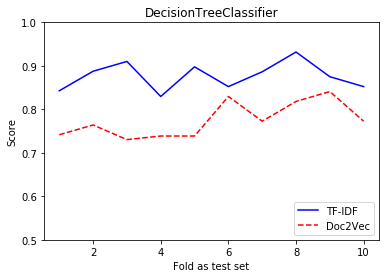

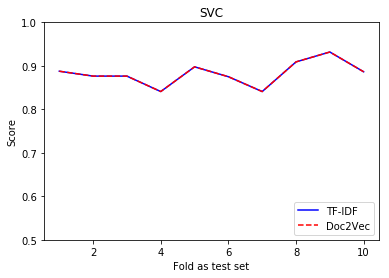

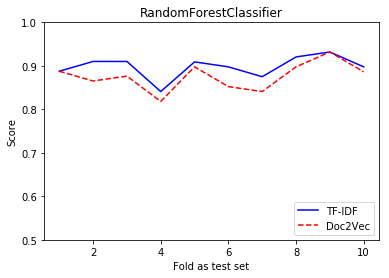

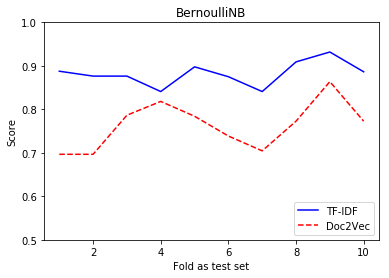

In [25]:
for c in cross_val:
    line_plot(c)